# **PLATE RECOGNITION**
Computer Vision

In [1]:
import os
from os import listdir, path

import string
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from scipy import stats as st

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from plate_classifier import *
from utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Obtendo o `dataset`

In [3]:
# !wget https://github.com/andrehochuli/teaching/raw/main/ComputerVision/Lecture%2004%20-%20Finding%20Components/dataset.zip -O dataset.zip
# !unzip dataset.zip

# Lendo o `dataset` e separando os componentes

In [4]:
# listando as imagens do diretório './dataset'

path = 'dataset'

dirs = listdir(path)
list_img = []
list_title = []

for file in dirs:
    list_img.append(cv2.imread(f'dataset/{file}'))
    list_title.append(file)

list_title[:10]

['aaaa000.jpg',
 'aaaa111.jpg',
 'aba1234.jpg',
 'abgap33.jpg',
 'anal334.jpg',
 'ancl550.jpg',
 'blam414.jpg',
 'bmw6220.jpg',
 'bn158-58.jpg',
 'bq-708-gp.jpg']

In [5]:
# aplicando filtros e kernel nas imagens
list_gray = []
list_thresh = []
for image in list_img:
    kernel = np.array([[0, -1,  0],
                       [-1,  5, -1],
                       [0, -1,  0]])

    filter2d = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)

    hsv_image = cv2.cvtColor(filter2d, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_image)
        
    clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(5,5))
    v = clahe.apply(v)
        
    hsv_image = cv2.merge([h, s, v])
    hsv_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

    gray = cv2.cvtColor(hsv_image ,cv2.COLOR_RGB2GRAY)
    gray = cv2.medianBlur(gray,3)

    _, thresh = cv2.threshold(
        gray, 127, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU
    )

    list_gray.append(gray )
    list_thresh.append(thresh)

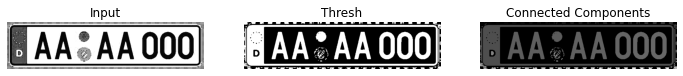

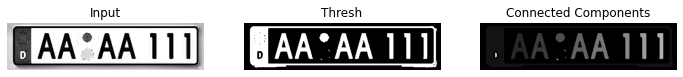

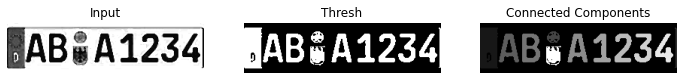

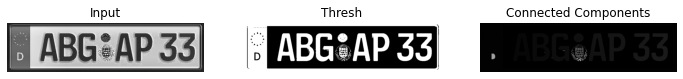

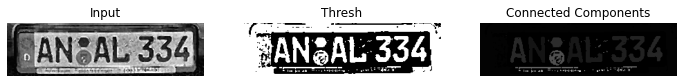

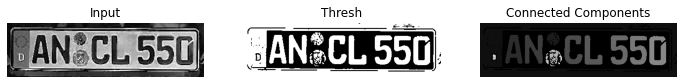

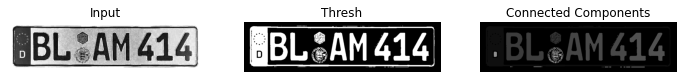

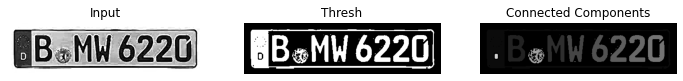

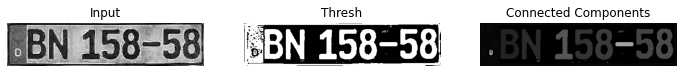

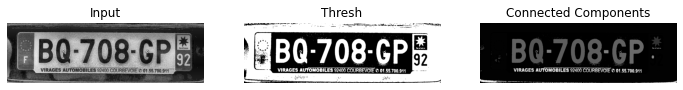

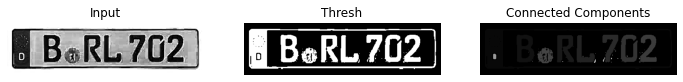

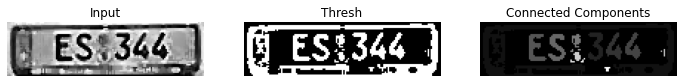

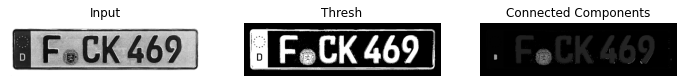

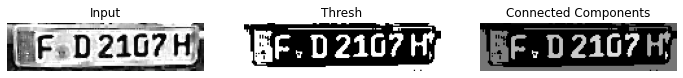

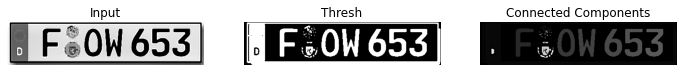

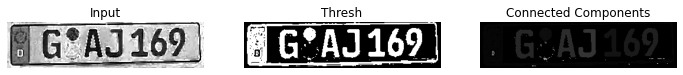

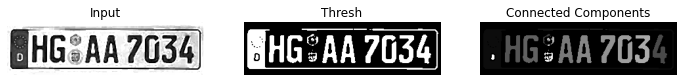

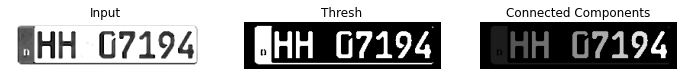

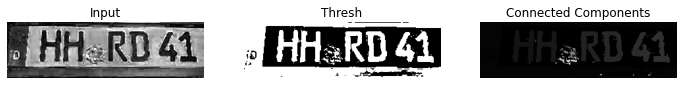

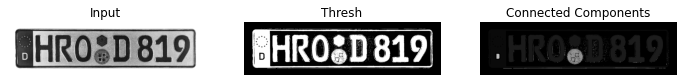

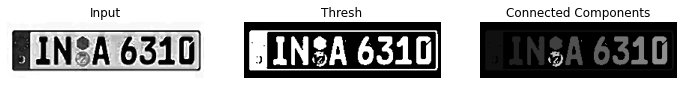

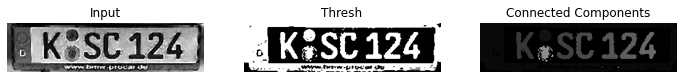

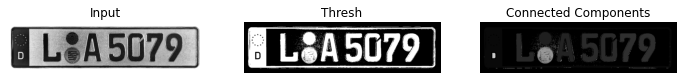

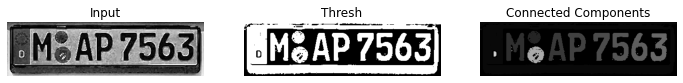

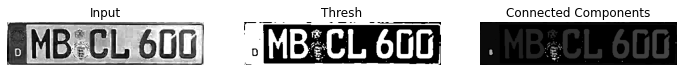

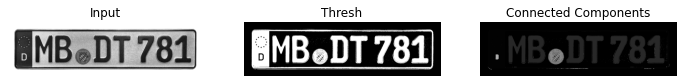

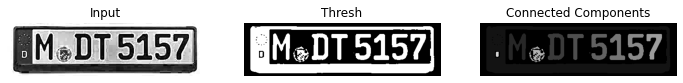

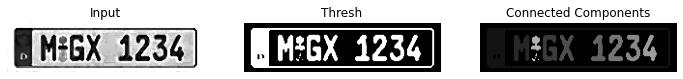

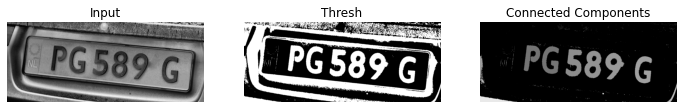

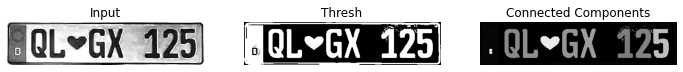

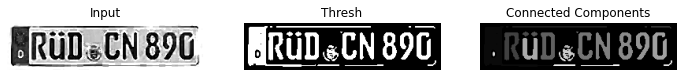

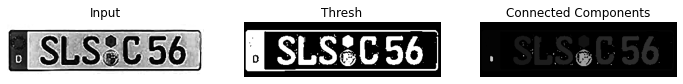

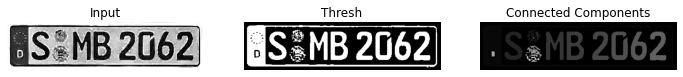

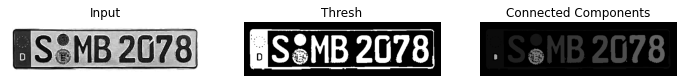

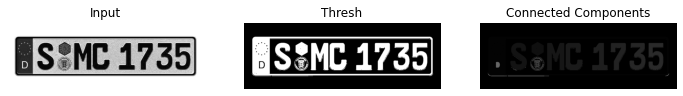

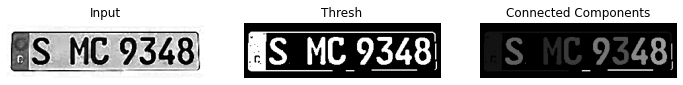

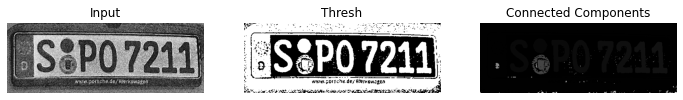

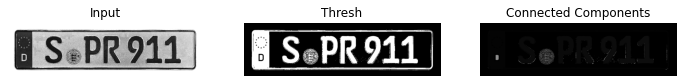

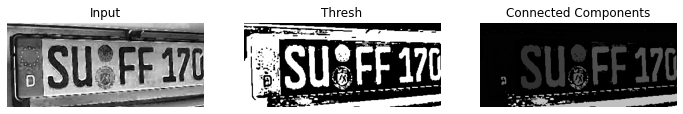

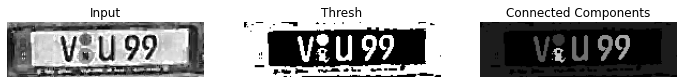

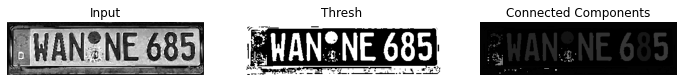

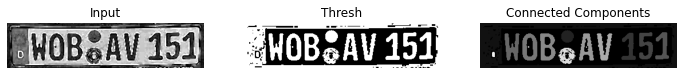

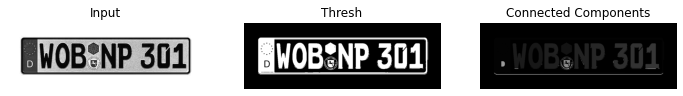

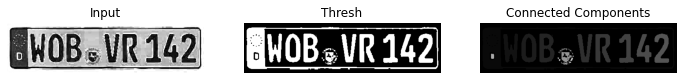

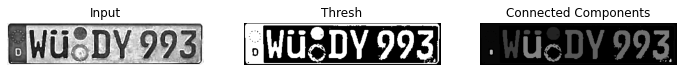

In [6]:
components_img = []
for gray, thresh in zip(list_gray, list_thresh):
    connectivity = 4
    
    num_labels, cc_image, stats, centroids = cv2.connectedComponentsWithStats(
        thresh, connectivity, cv2.CV_32S
    )

    components_img.append([num_labels, cc_image, stats, centroids])

    plot_sidebyside(
        [gray, thresh, cc_image],
        ['Input', 'Thresh', 'Connected Components'],
        colormap='gray'
    )

In [7]:
list_component = []
list_components = []
list_tittle = []
list_h = []
for components, gray, thresh in zip(components_img, list_gray, list_thresh):
    for i in range(components[0]):
        temp = components[1].copy()

        temp[components[1] == i] = 255
        temp[components[1] != i] = 0

        x, y, w, h = components[2][i][:4]
        area_total = components[2][0][4]
        area = components[2][i][4]
        porcentagem = area * 100 / area_total

        if porcentagem > 1.5:
            list_h.append(h)
            component = gray[y:y+h, x:x+w]
            component = cv2.resize(component,(64,64))    
            
            _, component = cv2.threshold(
                component, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU
            )
            
            list_component.append([x,h,component])

    list_component = [i for i in list_component[2:] if i[1] >= sum(list_h[2:])/len(list_h[2:]) * 0.8]
    list_components.append(list_component)
    list_component = []
    list_h = []

In [8]:
# removendo elemento destoante
del list_components[36][0]

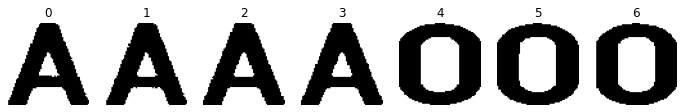

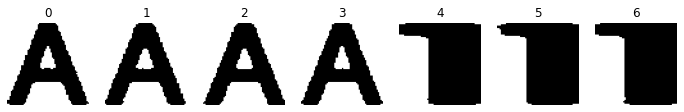

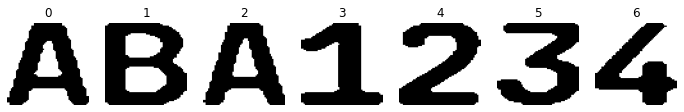

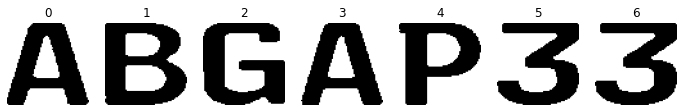

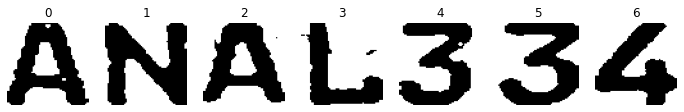

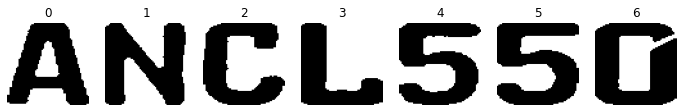

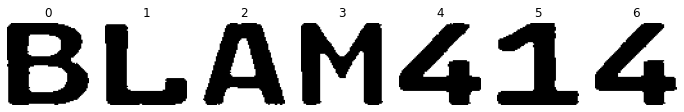

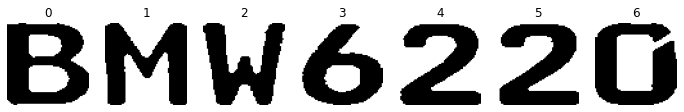

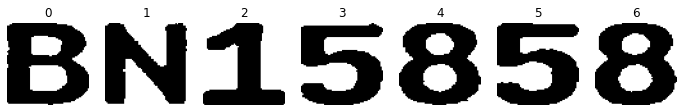

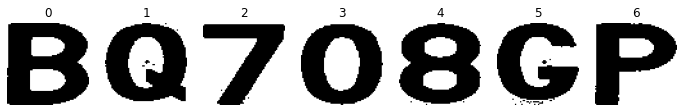

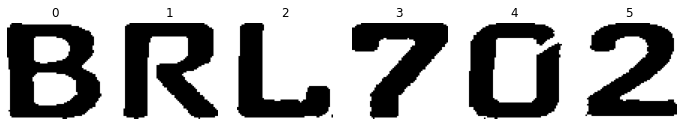

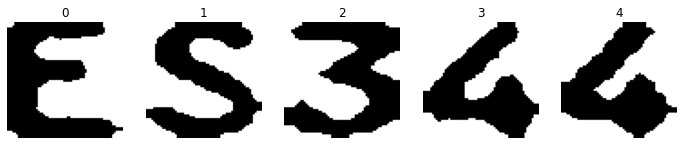

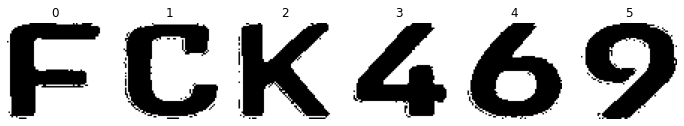

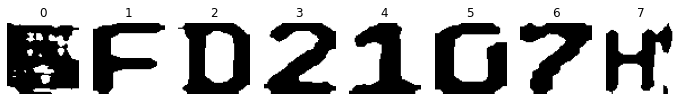

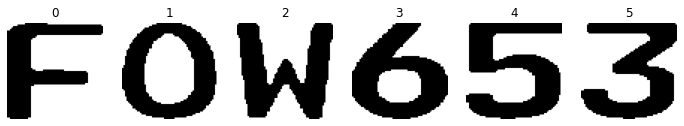

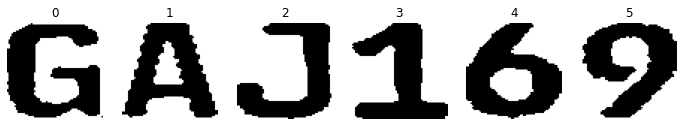

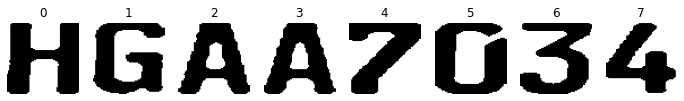

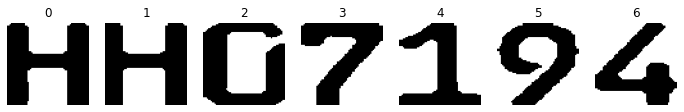

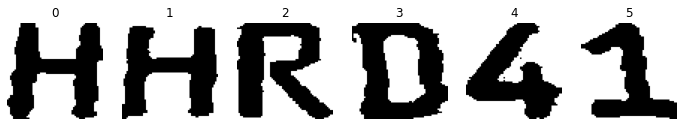

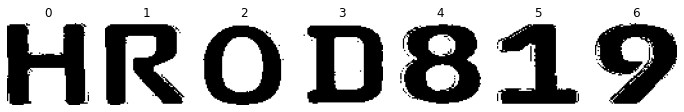

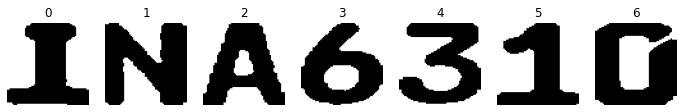

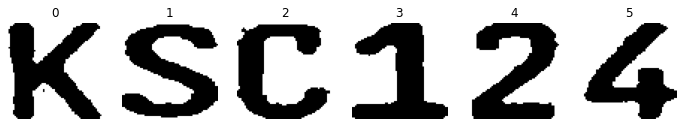

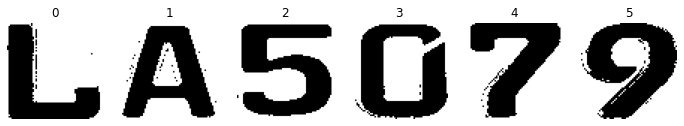

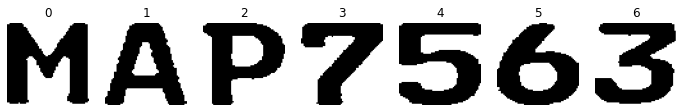

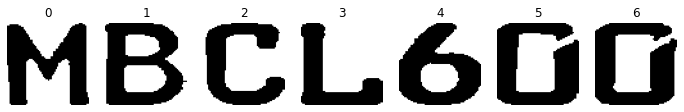

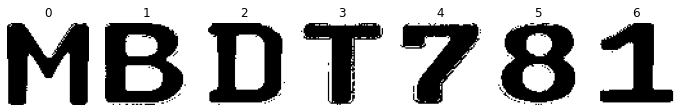

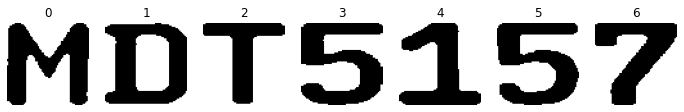

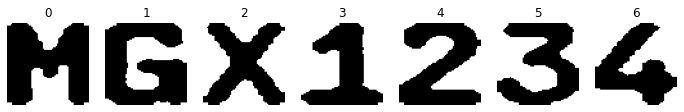

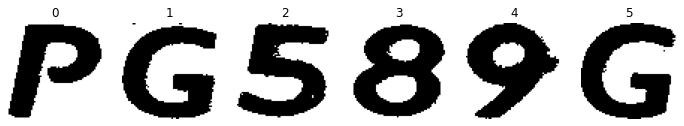

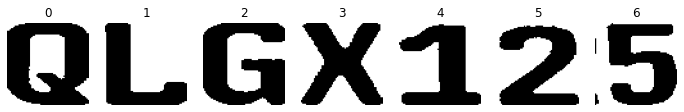

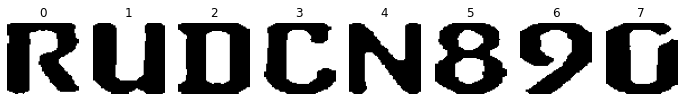

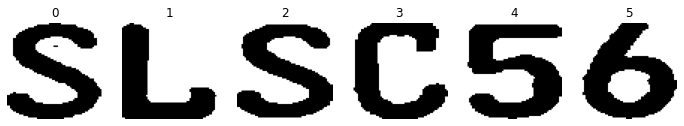

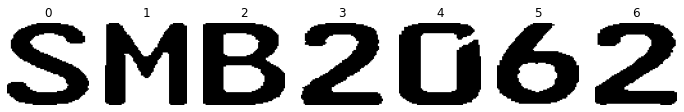

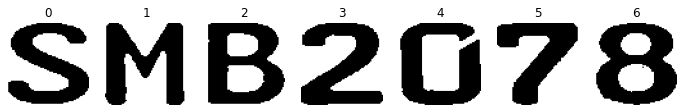

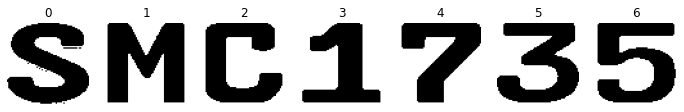

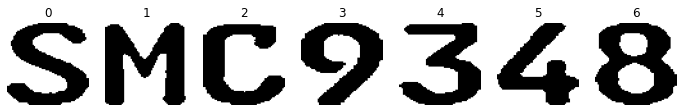

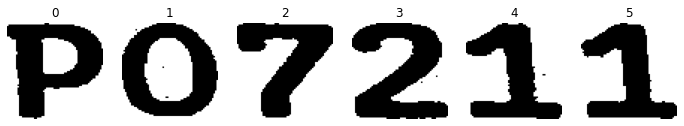

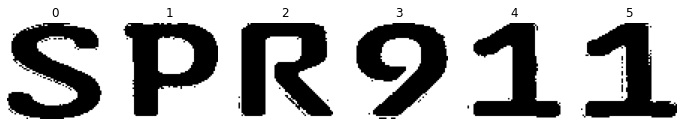

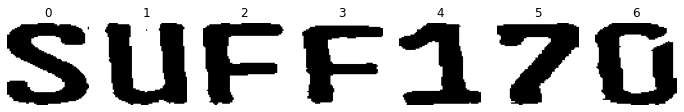

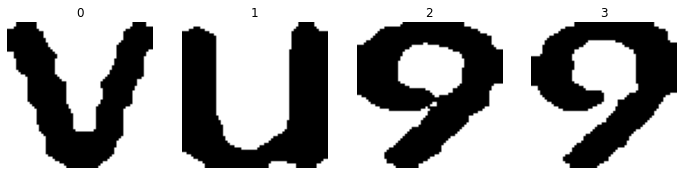

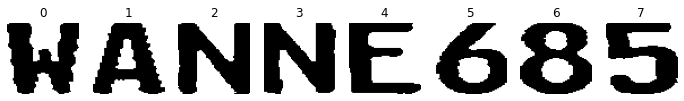

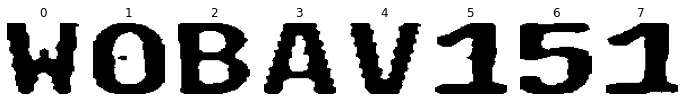

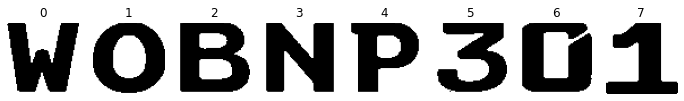

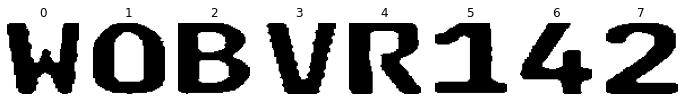

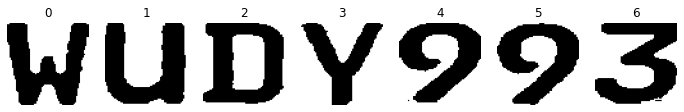

In [9]:
# exibindo matriz de componentes
components = []
list_comps = []

for comp_ in list_components:
    ordenado = sorted(comp_)
    n = range(len(ordenado) + 1)

    for i in ordenado:
      list_comps.append(i[2])

    components.append(list_comps)

    plot_sidebyside(
        list_comps,
        [str(tl_c) for tl_c in n],
        colormap='gray'
    )

    list_comps = []

# Criando bases sintéticas
Como as placas possuem distorções e sujeira, buscamos criar uma base sintética com todas as letras do alfabeto e os números de 0 a 9. Essa base de caracteres será utilizada como modelo padrão de cada caractere, onde serão comparados 2 a 2 com cada caractere que se deseja classificar. Exemplo: temos um caractere "4" obtido das placas, então comparamos ele com cada caractere da nossa base, de maneira a obter aquele que mais se assemelha à nossa imagem de entrada; esse caractere será nossa classificação.

In [10]:
def create_sintetic_base(fontScale=4, thickness=4, font=cv2.FONT_HERSHEY_SIMPLEX):
    # criamos uma matriz toda branca, 128x128, e inserimos
    # o texto através da função 'putText()'

    data = []
    for c in alf:
        m = np.ones((128,128))
        m = 255*m

        text = c

        # cv2.FONT_HERSHEY_SIMPLEX
        # cv2.FONT_HERSHEY_PLAIN         
        # cv2.FONT_HERSHEY_DUPLEX        
        # cv2.FONT_HERSHEY_COMPLEX       
        # cv2.FONT_HERSHEY_TRIPLEX       
        # cv2.FONT_HERSHEY_COMPLEX_SMALL 
        # cv2.FONT_HERSHEY_SCRIPT_SIMPLEX
        # cv2.FONT_HERSHEY_SCRIPT_COMPLEX
        # cv2.FONT_ITALIC 

        org = (18, 105)
        color = 0

        m = cv2.putText(m, text, org, font, fontScale, 
                        color, thickness, cv2.LINE_AA, False
        )
        
        data.append(m)
    return data

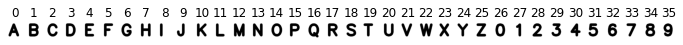

In [11]:
# exibindo a base sintética

sintetic_simplex = create_sintetic_base(fontScale=4, thickness=20, font=cv2.FONT_HERSHEY_SIMPLEX)
sintetic_simplex_h = create_sintetic_base(fontScale=4, thickness=30, font=cv2.FONT_HERSHEY_SIMPLEX)
sintetic_simplex_t = create_sintetic_base(fontScale=4, thickness=10, font=cv2.FONT_HERSHEY_SIMPLEX)
sintetic_script = create_sintetic_base(fontScale=4, thickness=20, font=cv2.FONT_HERSHEY_TRIPLEX)
sintetic_script_h = create_sintetic_base(fontScale=4, thickness=25, font=cv2.FONT_HERSHEY_TRIPLEX)

plot_sidebyside(
    sintetic_simplex,
    [str(i) for i in range(len(sintetic_simplex))],
    colormap='gray'
)

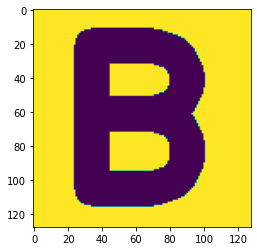

In [12]:
# exibindo o 'B'
plt.imshow(sintetic_simplex[1]);

Para podermos comparar os caracteres da nossa base com os extraídos das placas, precisamos cortar as bordas que "sobram" dos caracteres que iremos utilizar como base, bem como ajustar as imagens no mesmo tamanho, bem como ambas binarizadas.

In [13]:
# função que retorna o índice da linha superior
# a ser cortada

def get_borders(matrix):
    argmins = [np.argmin(i) for i in matrix]

    for i in range(len(argmins)):
        if argmins[i] != 0:
            idx = i-1
            break
    return idx

# obtendo os índices de cortes transpondo e rotacionando
# a imagem

def crop_image(matrix):
    rt = get_borders(matrix)
    rd = len(matrix) - get_borders(np.flipud(matrix))
    cl = get_borders(matrix.T)
    cr = len(matrix) - get_borders(np.flipud(matrix.T))
    return matrix[rt:rd, cl:cr]

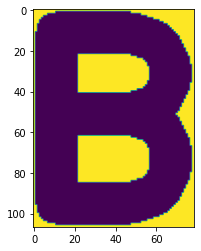

In [14]:
# imagem cortada
plt.imshow(crop_image(sintetic_simplex[1]));

In [15]:
def process_sintetic_base(data, cut_i=True, cut_1=True):
    # cortando cada caractere da base, fazendo um resize
    # e binarizando

    data_c = []
    for c in data:
        im = crop_image(c)

        im = cv2.resize(im, (64,64));
        _, im = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY)
        data_c.append(im)

    if cut_i:
        # reduzindo as bordas trocando o valor
        # 0 por 255

        data_c[8][:,:20] = 255
        data_c[8][:,40:] = 255

    if cut_1:
        # reduzindo pela direita
        data_c[27][:,50:] = 255

    return data_c

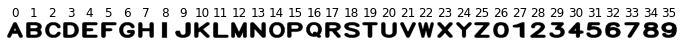

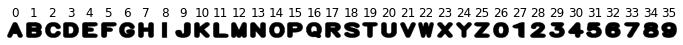

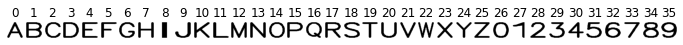

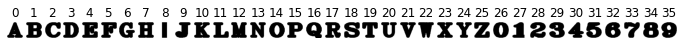

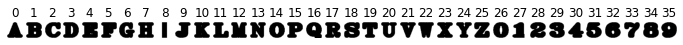

In [16]:
sintetic_simplex = process_sintetic_base(sintetic_simplex)
sintetic_simplex_h = process_sintetic_base(sintetic_simplex_h)
sintetic_simplex_t = process_sintetic_base(sintetic_simplex_t)
sintetic_script = process_sintetic_base(sintetic_script)
sintetic_script_h = process_sintetic_base(sintetic_script_h)

sintetic_basis = [sintetic_simplex,
                  sintetic_simplex_h,
                  sintetic_simplex_t,
                  sintetic_script,
                  sintetic_script_h]

for base in sintetic_basis:
    plot_sidebyside(
        base,
        [str(i) for i in range(len(base))],
        colormap='gray'
    )

## Testando as previsões a partir da base sintética

### Utilizando a placa como *input*

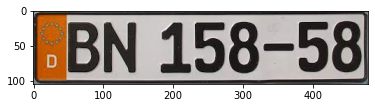

In [17]:
X_test = cv2.imread('./dataset/bn158-58.jpg')
plt.imshow(X_test);

num components = 11
components


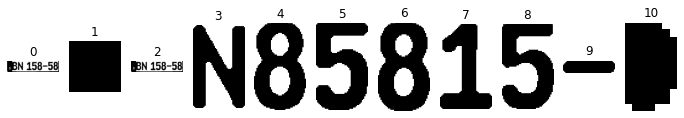


component 1 of 11


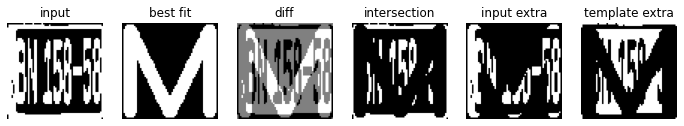

pred = M

component 2 of 11


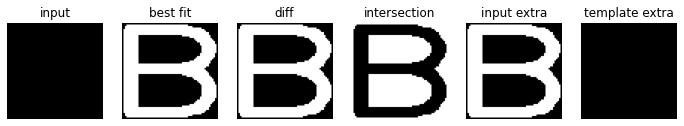

pred = B

component 3 of 11


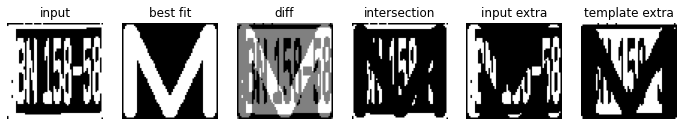

pred = M

component 4 of 11


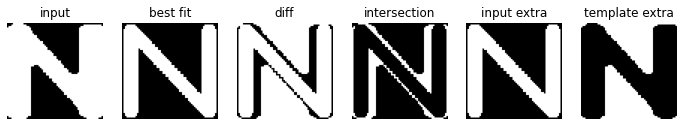

pred = N

component 5 of 11


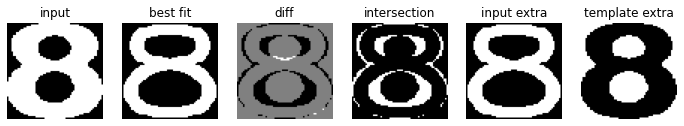

pred = 8

component 6 of 11


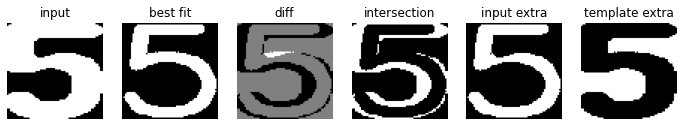

pred = 5

component 7 of 11


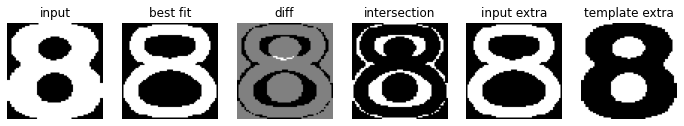

pred = 8

component 8 of 11


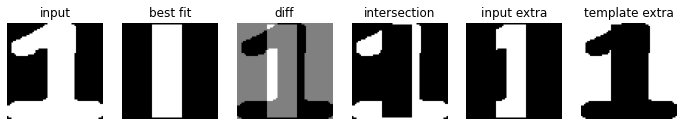

pred = I

component 9 of 11


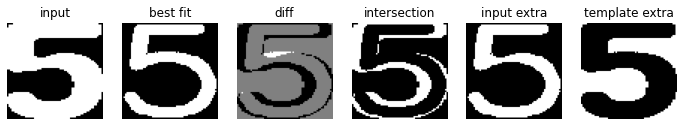

pred = 5

component 10 of 11


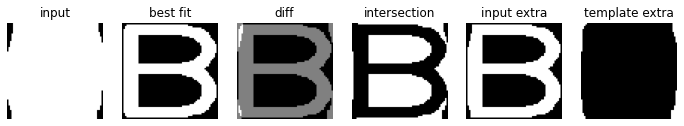

pred = B

component 11 of 11


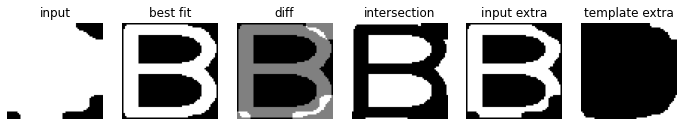

pred = B
output = MBMN858I5BB


In [18]:
clf = PlateClassifier()
clf.fit(sintetic_simplex_t, alf)
pred = clf.predict(X_test, verbose=True, show_scores=False)
print('output =', pred)

### Utilizando os componentes como *input*


component 1 of 7


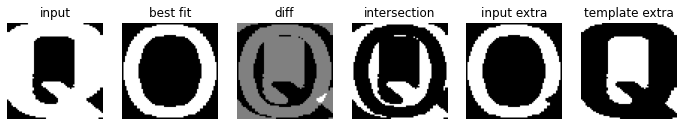

0    1471
9    1466
B    1444
D    1437
Q    1368
6    1298
O    1260
8    1206
G    1084
U    1038
M     982
R     874
C     851
5     848
E     794
J     723
S     697
N     574
P     571
2     547
3     439
H     382
L     337
F     139
Z      48
W     -31
K     -34
V    -309
7    -354
4    -641
1    -644
X    -709
T    -755
A    -814
Y    -976
I   -1246
dtype: int64
pred = 0

component 2 of 7


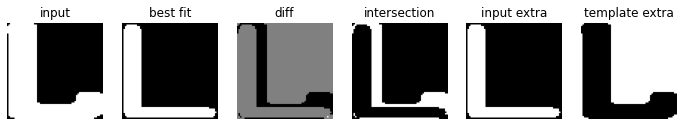

L    2661
E    2344
U    2003
D    2000
B    1965
C    1924
6    1912
0    1734
G    1728
F    1647
O    1646
N    1644
8    1643
5    1606
K    1576
S    1539
M    1518
H    1503
R    1458
Q    1361
9    1315
P    1275
J    1247
2    1137
Z    1136
3     903
X     880
W     727
A     688
V     665
Y     400
1     300
4     279
T     183
7     149
I    -170
dtype: int64
pred = L

component 3 of 7


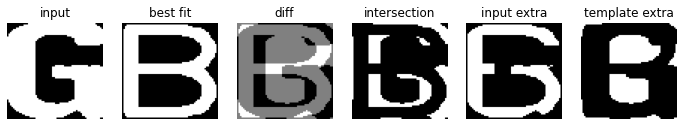

B    1796
6    1782
S    1562
8    1537
G    1436
9    1422
D    1417
0    1409
E    1368
O    1258
C    1158
5    1152
U    1123
Q    1105
R    1103
N     962
H     923
P     881
M     857
F     800
3     743
J     724
L     644
2     485
Z     406
K     351
W      24
7    -152
X    -249
V    -410
A    -444
T    -493
4    -571
1    -571
Y    -753
I   -1083
dtype: int64
pred = B

component 4 of 7


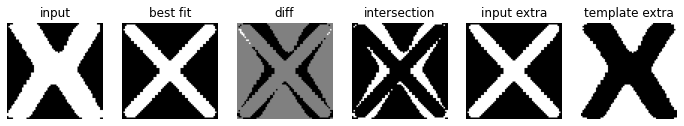

X    2285
Z    1362
A    1214
K    1187
W     914
Y     836
2     808
R     766
N     703
8     681
4     649
1     589
7     564
S     523
V     519
3     514
5     461
I     356
9     341
6     338
E     272
M     244
T     181
B     172
F     163
G      88
P      64
Q      63
C     -16
H     -44
J     -66
0    -161
D    -171
O    -195
L    -224
U    -393
dtype: int64
pred = X

component 5 of 7


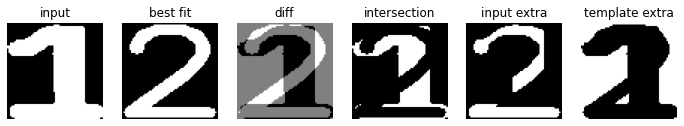

2    1660
1    1645
3    1234
Z    1224
I    1121
S    1084
9    1070
8    1068
5    1034
4     982
A     941
6     935
X     932
G     874
7     792
E     791
C     764
R     757
B     739
T     712
Q     705
W     692
0     655
Y     644
D     642
K     623
O     609
L     544
V     504
M     196
P     139
J     105
N     100
F      91
U     -99
H    -359
dtype: int64
pred = 2

component 6 of 7


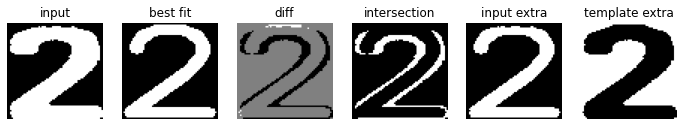

2    2614
9    1658
Z    1593
8    1293
B    1276
S    1261
7    1242
0    1138
G    1123
C    1100
O    1053
R     988
D     981
X     947
3     934
5     917
6     908
V     906
Q     906
M     898
1     880
P     871
E     860
I     713
L     655
J     645
W     623
Y     590
U     483
A     455
T     427
N     295
4     175
H     175
F     160
K      38
dtype: int64
pred = 2

component 7 of 7


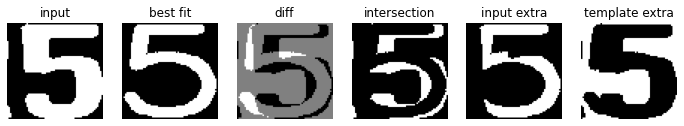

5    2169
8    2137
6    2043
3    1865
S    1787
9    1473
B    1445
0    1361
G    1292
O    1252
J    1150
2    1097
C    1077
Z    1060
Q    1045
E     846
D     832
I     831
7     754
1     737
T     686
W     669
U     634
X     567
A     543
R     542
Y     501
N     485
4     374
F     362
H     353
M     335
V     316
P     161
L     -46
K    -255
dtype: int64
pred = 5
output = 0LBX225


In [19]:
clf = PlateClassifier()
clf.fit(sintetic_simplex_t, alf)
pred = clf.predict(components[29], split=False, verbose=True, show_scores=True)
print('output =', pred)

# Criando uma base derivada do `dataset`

In [20]:
# lista de texto das placas do 'dataset'
plates_texts = [i.split('.jpg')[0] \
                .split('.png')[0] \
                .replace('-', '') \
                .upper() for i in list_title]
plates_texts[:10]

['AAAA000',
 'AAAA111',
 'ABA1234',
 'ABGAP33',
 'ANAL334',
 'ANCL550',
 'BLAM414',
 'BMW6220',
 'BN15858',
 'BQ708GP']

In [21]:
# criando uma matriz com os rótulos das placas
labels = []
for plate_str in plates_texts:
    plate_labels = [i for i in plate_str]
    labels.append(plate_labels)

labels[:5]

[['A', 'A', 'A', 'A', '0', '0', '0'],
 ['A', 'A', 'A', 'A', '1', '1', '1'],
 ['A', 'B', 'A', '1', '2', '3', '4'],
 ['A', 'B', 'G', 'A', 'P', '3', '3'],
 ['A', 'N', 'A', 'L', '3', '3', '4']]

In [22]:
# planificando a matriz de caracteres e rótulos
labels_flat = [i for k in labels for i in k]
components_flat = [i for k in components for i in k]

In [23]:
# extraindo as métricas para cada caractere da matriz

features = ['black_pixels',         # número de pixels pretos     
            'black_percent',        # porcentagem de pixels pretos em relação ao total   
            'white_pixels',         # número de pixels brancos   
            'white_percent',        # porcentagem de pixels brancos em relação ao total   
            'max_width',            # número de pixels pretos de largura máxima
            'row_max_width',        # índice da linha de número de pixels pretos de largura máxima    
            'min_width',            # número de pixels pretos de largura mínima   
            'row_min_width',        # índice da linha de número de pixels pretos de largura mínima      
            'max_height',           # número de pixels pretos de altura máxima  
            'col_max_height',       # índice da coluna de número de pixels pretos de altura máxima 
            'min_height',           # número de pixels pretos de altura mínima
            'col_min_height',       # índice da coluna de número de pixels pretos de altura mínima
            'diagp_black_pixels',       
            'diags_black_pixels',       
            'midh_black_pixels',        
            'midh_white_pixels',        
            'midv_black_pixels',        
            'midv_white_pixels',
            '1','2','3','4','5','6','7','8','9','10','11','12','13',
            '14','15','16','17','18','19','20','21','22','23','24',
            '25','26','27','28','29','30','31','32']

# # feature names auto
# features = [str(i) for i in range(len(get_image_stats(components[0][0])))]        

data = {i: [] for i in features}
data['label'] = []
for c, label in zip(components_flat, labels_flat):
    data['label'].append(label)

    stats = get_image_stats(c,
                            return_as='json',
                            feature_names=features,
                            templates=sintetic_simplex)
    for k, v in zip(list(stats.keys()),
                    list(stats.values())):
        data[k].append(v)

In [24]:
# criando um df com os dados extraídos
df = pd.DataFrame()

for key, value in zip(list(data.keys()),
                      list(data.values())):
    df[key] = value

df.head(10)

black_pixels  black_percent  white_pixels  white_percent  max_width  row_max_width  min_width  row_min_width  max_height  col_max_height  min_height  col_min_height  diagp_black_pixels  diags_black_pixels  midh_black_pixels  midh_white_pixels  midv_black_pixels  midv_white_pixels           1           2    3    4    5    6    7    8    9   10    11    12    13    14    15    16    17   18         19         20    21  22    23  24    25  26    27  28    29  30    31  32 label
0          1944       0.474609          2152       0.525391         53             48         12              0          47              24           0               0                  33                  34                 30                 34                 32                 32  133.974609  127.335500  391  411  570  572  633  613  454  452   961   983   802  1142  1087  1065  1246  906  30.375000  30.375000  3672   0  3672   0  1672   1  1354  24  1354  24  1672   1     A
1          1937       0.472900          2159       0.527100         53             48         12              0          48              24           0               0                  32                  35                 31                 33                 31                 33  134.410400  127.312593  394  410  564  569  630  614  460  455   958   979   804  1133  1090  1069  1244  915  30.265625  30.265625  3655   0  3655   0  1669   1  1352  24  1352  24  1669   1     A
2          1969       0.480713          2127       0.519287         54             48         13              0          47              24           3              63                  34                  35                 32                 32                 31                 33  132.418213  127.405107  410  407  578  574  614  617  446  450   988   981   817  1152  1060  1067  1231  896  30.765625  30.765625  3675   0  3675   0  1641   1  1387  24  1387  24  1641   1     A
3          1965       0.479736          2131       0.520264         54             48         14              0          47              24           3              63                  34                  35                 33                 31                 31                 33  132.667236  127.395250  407  409  575  574  617  615  449  450   982   983   816  1149  1066  1065  1232  899  30.703125  30.703125  3671   0  3671   0  1648   1  1384  24  1384  24  1648   1     A
4          2416       0.589844          1680       0.410156         58             10          8              0          60              16          20              27                  20                  20                 34                 30                 21                 43  104.589844  125.424777  603  601  606  606  421  423  418  418  1209  1207  1204  1212   839   841   844  836  37.750000  37.750000  3408  14  3408  14  1224  23  2012   8  2012   8  1224  23     0
5          2421       0.591064          1675       0.408936         56             10          7              0          60              46          20              27                  22                  21                 35                 29                 21                 43  104.278564  125.367519  602  599  605  615  422  425  419  409  1207  1214  1201  1220   841   834   847  828  37.828125  37.828125  3467  26  3467  26  1207  23  2016   8  2016   8  1207  23     0
6          2385       0.582275          1711       0.417725         56             10          6              0          60              17           0               0                  21                  22                 34                 30                 21                 43  106.519775  125.761998  587  595  596  607  437  429  428  417  1183  1202  1182  1203   865   846   866  845  37.265625  37.265625  3483  26  3483  26  1213  23  1979   8  1979   8  1213  23     0
7          1833       0.447510          2263       0.552490         50             45         13              0          46              25

In [25]:
# agrupando e agregando as métricas por caractere

df_grouped = df.groupby('label').agg('mean')
df_grouped = df_grouped.rename(columns={i: i + '_mean' for i in df_grouped.columns})
df_grouped

black_pixels_mean  black_percent_mean  white_pixels_mean  white_percent_mean  max_width_mean  row_max_width_mean  min_width_mean  row_min_width_mean  max_height_mean  col_max_height_mean  min_height_mean  col_min_height_mean  diagp_black_pixels_mean  diags_black_pixels_mean  midh_black_pixels_mean  midh_white_pixels_mean  midv_black_pixels_mean  midv_white_pixels_mean      1_mean      2_mean      3_mean      4_mean      5_mean      6_mean      7_mean      8_mean      9_mean     10_mean      11_mean      12_mean      13_mean      14_mean      15_mean      16_mean      17_mean      18_mean    19_mean    20_mean      21_mean    22_mean      23_mean    24_mean      25_mean    26_mean      27_mean    28_mean      29_mean    30_mean      31_mean    32_mean
label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
0            2314.526316            0.565070        1781.473684            0.434930       60.105263           34.315789       12.947368           22.263158        57.684211            20.789474         9.947368            24.000000                28.789474                28.526316               34.684211               29.315789               28.052632               35.947368  110.907175  125.606457  575.105263  578.105263  580.947368  580.368421  448.894737  445.894737  443.052632  443.631579  1156.052632  1158.473684  1153.210526  1161.315789   891.947368   889.526316   894.789474   886.684211  36.164474  36.164474  3330.052632  20.842105  3330.052632  20.842105  1289.842105  18.105263  1832.473684  10.263158  1832.473684  10.263158  1289.842105  18.105263
1            2113.037037            0.515878        1982.962963            0.484122       59.925926           39.444444       12.222222           37.851852        59.703704            33.444444         4.888889            23.111111                36.740741                32.777778               25.296296               38.703704               44.000000               20.000000  123.451063  125.979775  466.814815  582.444444  426.925926  636.851852  557.185185  441.555556  597.074074  387.148148   893.740741  1219.296296  1049.259259  1063.777778  1154.259259   828.703704   998.740741   984.222222  33.016204  33.016204  3238.296296  24.407407  3238.296296  24.407407  1528.814815   9.962963  1499.592593  11.074074  1499.592593  11.074074  1528.814815   9.962963
2            2205.615385            0.538480        1890.384615            0.461520       61.230769           49.384615       10.538462           22.307692        55.846154            29.846154         4.307692            24.000000                32.692308                38.307692               28.076923               35.923077               38.769231               25.230769  117.687519  126.623956  467.692308  586.923077  571.538462  579.461538  556.307692  437.076923  452.461538  444.538462  1039.230769  1166.384615  1054.615385  1151.000000  1008.769231   881.615385   993.384615   897.000000  34.462740  34.462740  3356.846154  23.692308  3356.846154  23.692308  1396.692308  13.076923  1551.384615  11.307692  1551.384615  11.307692  1396.692308  13.076923
3            2177.000000            0.531494        1919.000000            0.468506       59.533333           20.066667       11.200000           36.866667        55.1

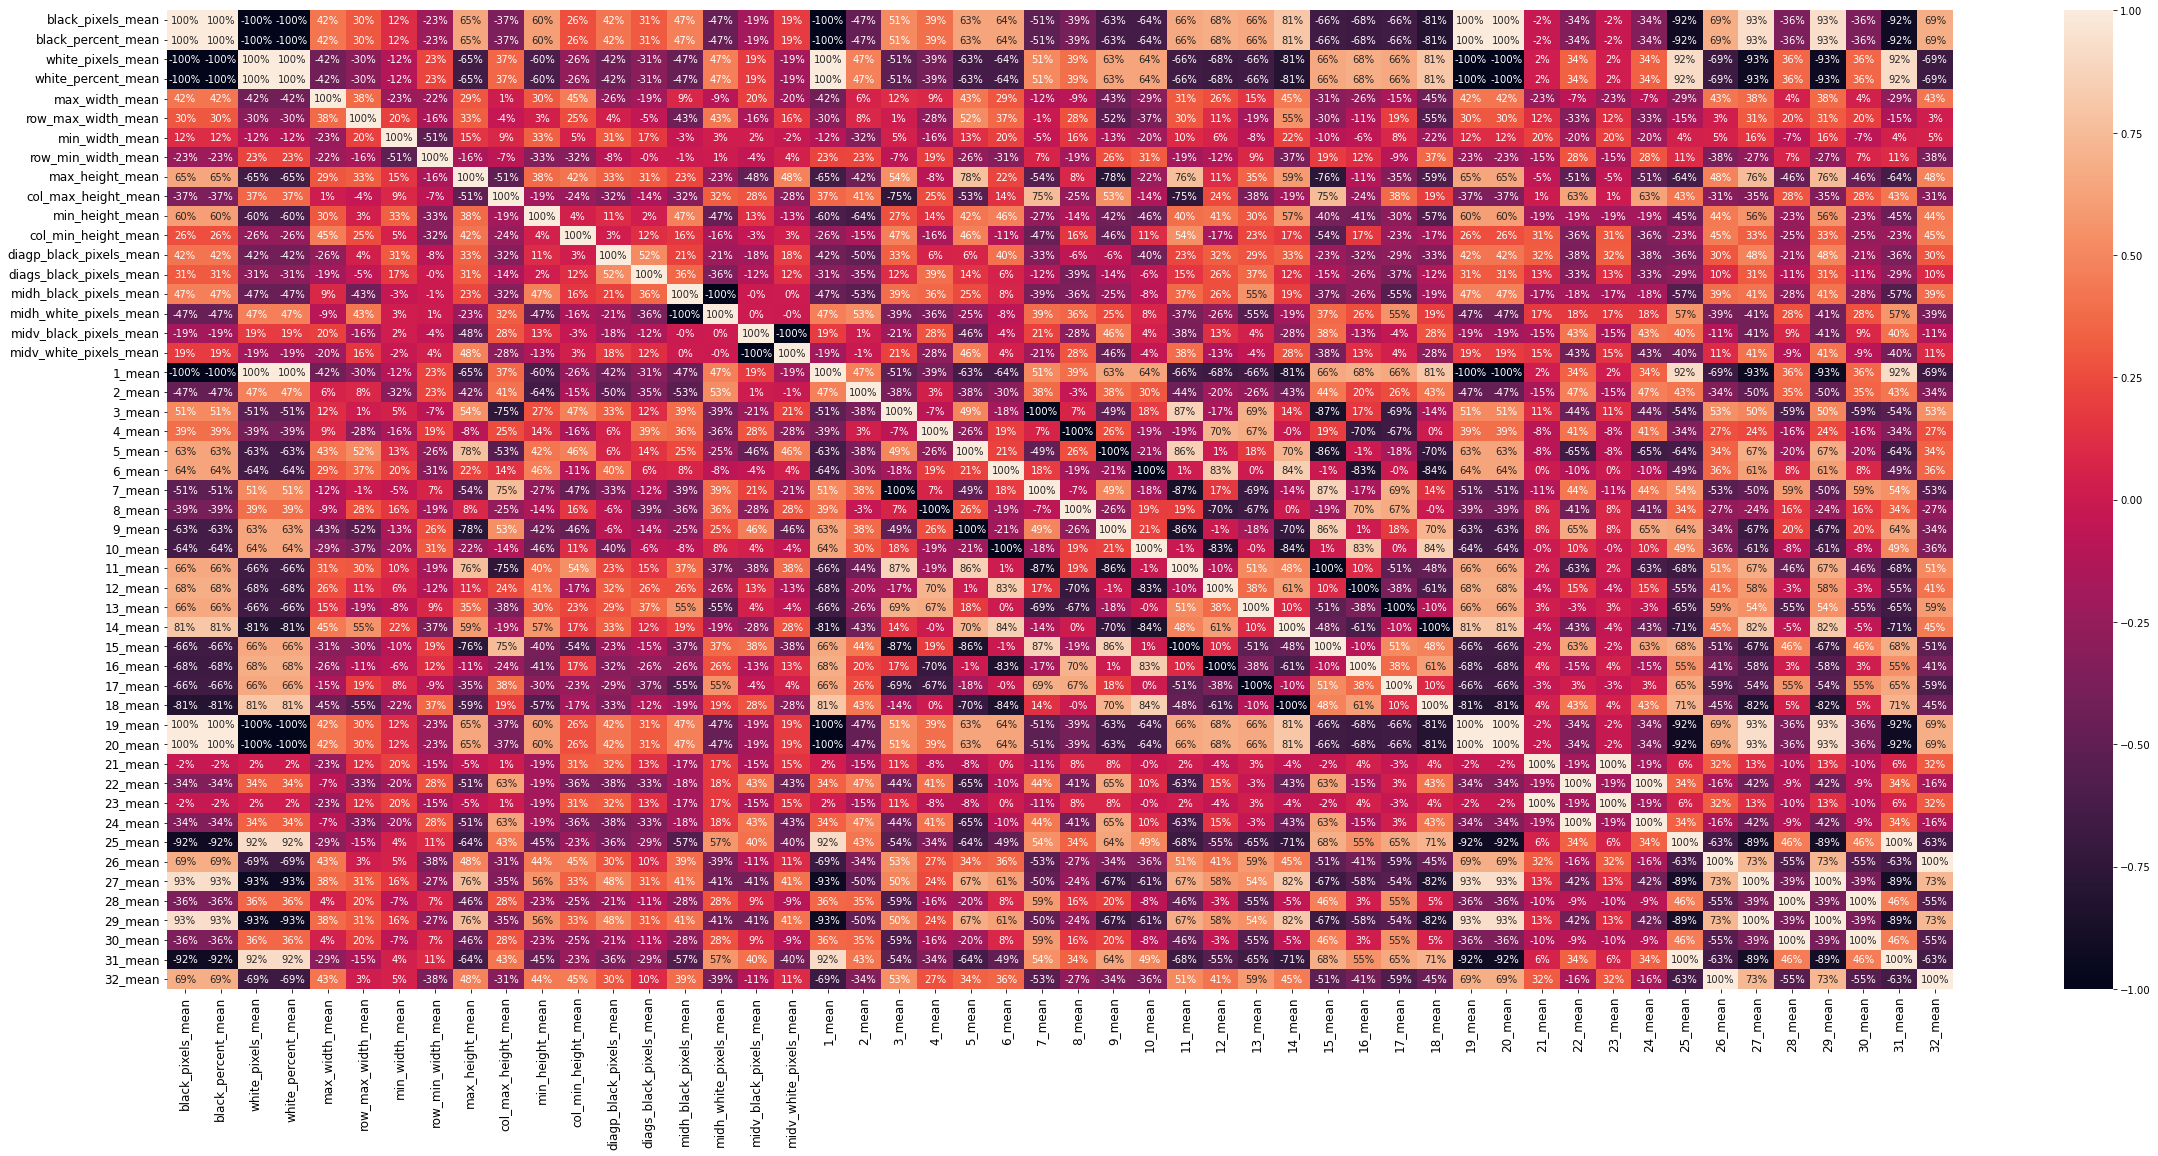

In [26]:
# correlações
cor = df_grouped[df_grouped.columns[:]].corr()

plt.figure(figsize=(40,18))
sns.heatmap(cor, annot=True, fmt='.0%')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Realizando previsões com o modelo

In [27]:
# instanciando o modelo
clf = PlateClassifier()
clf.fit(X_train=sintetic_simplex, y_train=alf, stats=df_grouped)

preds = []
_preds = []
for i, y_true in zip(range(len(components)), plates_texts):
    X_test = components[i]

    # realizando previsões a partir da base sintética
    pred = clf.predict(X_test, split=False, verbose=False, show_scores=False)
    preds.append(pred)

    # realizando previsões a partir da base de features
    # métodos alternativos
    _pred = clf._predict(X_test,
                         templates=sintetic_simplex,
                         verbose=False)
                         
    _preds.append(_pred)

## Resultados do modelo baseado na base sintética

In [28]:
df_output = prediction_results(preds, plates_texts)
df_output

true      pred  hits  len     score  equal
0    AAAA000   AAAABBB     4    7  0.571429      0
1    AAAA111   AAAA333     4    7  0.571429      0
2    ABA1234   ABA1234     7    7  1.000000      1
3    ABGAP33   ABBAP33     6    7  0.857143      0
4    ANAL334   ANAL334     7    7  1.000000      1
5    ANCL550   ANCLBBB     4    7  0.571429      0
6    BLAM414   BLAN424     5    7  0.714286      0
7    BMW6220   BNW822D     4    7  0.571429      0
8    BN15858   BN2B8B8     4    7  0.571429      0
9    BQ708GP   B070BGP     5    7  0.714286      0
10    BRL702    BRL7B2     5    6  0.833333      0
11     ES344     ES344     5    5  1.000000      1
12    FCK469    FCK469     6    6  1.000000      1
13   FD2107H  BFB21D7K     0    7  0.000000      0
14    FOW653    FON653     5    6  0.833333      0
15    GAJ169    BAJ269     4    6  0.666667      0
16  HGAA7034  HBAAZB34     5    8  0.625000      0
17   HH07194   HHB7194     6    7  0.857143      0
18    HHRD41    HHRB42     4    6  0.666667      0
19   HROD819   HRO8829     5    7  0.714286      0
20   INA6310   ZNA631B     5    7  0.714286      0
21    KSC124    KSC124     6    6  1.000000      1
22    LA5079    LA5079     6    6  1.000000      1
23   MAP7563   NAP7563     6    7  0.857143      0
24   MBCL600   HBCL6BB     4    7  0.571429      0
25   MBDT781   NB8T781     5    7  0.714286      0
26   MDT5157   NBT5257     4    7  0.571429      0
27   MGX1234   NBX1Z34     4    7  0.571429      0
28    PG589G    PGS89G     5    6  0.833333      0
29   QLGX125   DLBX125     5    7  0.714286      0
30  RUDCN890  RUBCN89B     6    8  0.750000      0
31    SLSC56    SLSC56     6    6  1.000000      1
32   SMB2062   SNB2B52     4    7  0.571429      0
33   SMB2078   SNB2D78     5    7  0.714286      0
34   SMC1735   SND1735     5    7  0.714286      0
35   SMC9348   SHC9348     6    7  0.857143      0
36   SPO7211    PO7222     1    7  0.142857      0
37    SPR911    SPR912     5    6  0.833333      0
38   SUFF170   SUFF17B     6    7  0.857143      0
39      VU99      VU99     4    4  1.000000      1
40  WANNE685  NANNE685     7    8  0.875000      0
41  WOBAV151  N0BAV1B2     4    8  0.500000      0
42  WOBNP301  W0BNP3B1     6    8  0.750000      0
43  WOBVR142  N0BVR242     5    8  0.625000      0
44   WUDY993   WUBV993     5    7  0.714286      0

In [29]:
# acurácia global das placas
print('accuracy =', df_output['equal'].sum() / len(df_output))
print('hits =', df_output['equal'].sum(), 'of', len(df_output))

accuracy = 0.17777777777777778
hits = 8 of 45


In [30]:
# acurácia total dos caracteres
print('accuracy =', df_output['hits'].sum() / df_output['len'].sum())
print('hits =', df_output['hits'].sum(), 'of', df_output['len'].sum())

accuracy = 0.7189542483660131
hits = 220 of 306


In [31]:
df_acc = summary_results(df_output)
df_acc

hits of total  accuracy
A      24 of 24  1.000000
B      14 of 14  1.000000
C        7 of 8  0.875000
D        0 of 7  0.000000
E        2 of 2  1.000000
F        4 of 5  0.800000
G        3 of 8  0.375000
H        6 of 7  0.857143
I        0 of 1  0.000000
J        1 of 1  1.000000
K        2 of 2  1.000000
L        8 of 8  1.000000
M       0 of 11  0.000000
N        8 of 8  1.000000
O        2 of 6  0.333333
P        6 of 7  0.857143
Q        0 of 2  0.000000
R        6 of 6  1.000000
S      10 of 11  0.909091
T        2 of 2  1.000000
U        4 of 4  1.000000
V        3 of 3  1.000000
W        3 of 7  0.428571
X        2 of 2  1.000000
Y        0 of 1  0.000000
Z        0 of 0       NaN
0       2 of 19  0.105263
1      12 of 26  0.461538
2      11 of 13  0.846154
3      15 of 15  1.000000
4      14 of 14  1.000000
5       9 of 15  0.600000
6       8 of 10  0.800000
7      10 of 13  0.769231
8       9 of 10  0.900000
9      13 of 13  1.000000

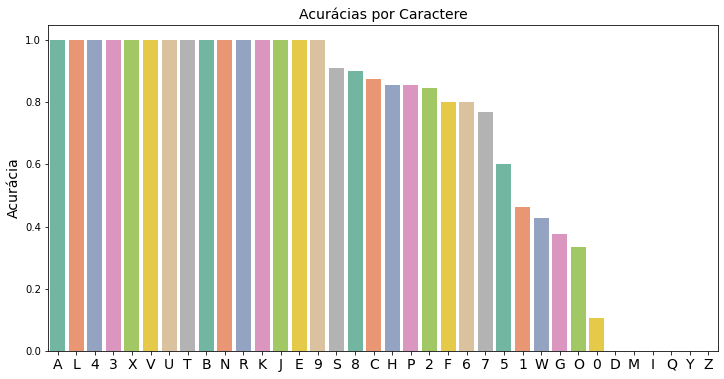

In [32]:
summary_plot(df_acc)

## Resultados do modelo baseado na base derivada

In [33]:
_df_output = prediction_results(_preds, plates_texts)
_df_output

true      pred  hits  len     score  equal
0    AAAA000   LLAAKNN     2    7  0.285714      0
1    AAAA111   LLLLXXX     0    7  0.000000      0
2    ABA1234   JBJ4214     3    7  0.428571      0
3    ABGAP33   JBWJP11     2    7  0.285714      0
4    ANAL334   JNJL414     3    7  0.428571      0
5    ANCL550   6NDLRBX     2    7  0.285714      0
6    BLAM414   BLJR444     4    7  0.571429      0
7    BMW6220   BR6622K     4    7  0.571429      0
8    BN15858   BN4RBBB     2    7  0.285714      0
9    BQ708GP   BUYQBSP     2    7  0.285714      0
10    BRL702    BRL707     5    6  0.833333      0
11     ES344     EV344     4    5  0.800000      0
12    FCK469    FVV4J9     3    6  0.500000      0
13   FD2107H  XFT24K74     0    7  0.000000      0
14    FOW653    FAW651     4    6  0.666667      0
15    GAJ169    WJ44SI     0    6  0.000000      0
16  HGAA7034  BW66PX34     2    8  0.250000      0
17   HH07194   BNWY494     2    7  0.285714      0
18    HHRD41    RGDW44     1    6  0.166667      0
19   HROD819   RCATQ4I     0    7  0.000000      0
20   INA6310   1B2631X     3    7  0.428571      0
21    KSC124    SMF4H4     1    6  0.166667      0
22    LA5079    LJM6YI     1    6  0.166667      0
23   MAP7563   BJP7R63     4    7  0.571429      0
24   MBCL600   RDVL6KK     2    7  0.285714      0
25   MBDT781   RBTYY8Y     2    7  0.285714      0
26   MDT5157   RTYC4C7     1    7  0.142857      0
27   MGX1234   BXA4234     3    7  0.428571      0
28    PG589G    PA989A     3    6  0.500000      0
29   QLGX125   XLX8121     3    7  0.428571      0
30  RUDCN890  BBXFNKTX     1    8  0.125000      0
31    SLSC56    VLALCA     1    6  0.166667      0
32   SMB2062   ARB2K62     4    7  0.571429      0
33   SMB2078   ARK2W7N     2    7  0.285714      0
34   SMC1735   QBG473R     2    7  0.285714      0
35   SMC9348   JRFI14N     1    7  0.142857      0
36   SPO7211    PO7244     0    7  0.000000      0
37    SPR911    MPR944     3    6  0.500000      0
38   SUFF170   SUEF47W     4    7  0.571429      0
39      VU99      VUI9     3    4  0.750000      0
40  WANNE685  X6NNE6BC     4    8  0.500000      0
41  WOBAV151  WKB6V1C1     5    8  0.625000      0
42  WOBNP301  WQBBP3X1     5    8  0.625000      0
43  WOBVR142  WUBVB142     6    8  0.750000      0
44   WUDY993   WUWYII3     4    7  0.571429      0

In [34]:
# acurácia global das placas
print('accuracy =', _df_output['equal'].sum() / len(_df_output))
print('hits =', _df_output['equal'].sum(), 'of', len(_df_output))

accuracy = 0.0
hits = 0 of 45


In [35]:
# acurácia total dos caracteres
print('accuracy =', _df_output['hits'].sum() / _df_output['len'].sum())
print('hits =', _df_output['hits'].sum(), 'of', _df_output['len'].sum())

accuracy = 0.369281045751634
hits = 113 of 306


In [36]:
_df_acc = summary_results(_df_output)
_df_acc

hits of total  accuracy
A       2 of 24  0.083333
B      12 of 14  0.857143
C        0 of 8  0.000000
D        0 of 7  0.000000
E        2 of 2  1.000000
F        3 of 5  0.600000
G        0 of 8  0.000000
H        0 of 7  0.000000
I        0 of 1  0.000000
J        0 of 1  0.000000
K        0 of 2  0.000000
L        8 of 8  1.000000
M       0 of 11  0.000000
N        6 of 8  0.750000
O        0 of 6  0.000000
P        6 of 7  0.857143
Q        0 of 2  0.000000
R        2 of 6  0.333333
S       1 of 11  0.090909
T        0 of 2  0.000000
U        3 of 4  0.750000
V        3 of 3  1.000000
W        5 of 7  0.714286
X        0 of 2  0.000000
Y        1 of 1  1.000000
Z        0 of 0       NaN
0       1 of 19  0.052632
1       6 of 26  0.230769
2       9 of 13  0.692308
3       8 of 15  0.533333
4      14 of 14  1.000000
5       1 of 15  0.066667
6       7 of 10  0.700000
7       6 of 13  0.461538
8       2 of 10  0.200000
9       5 of 13  0.384615

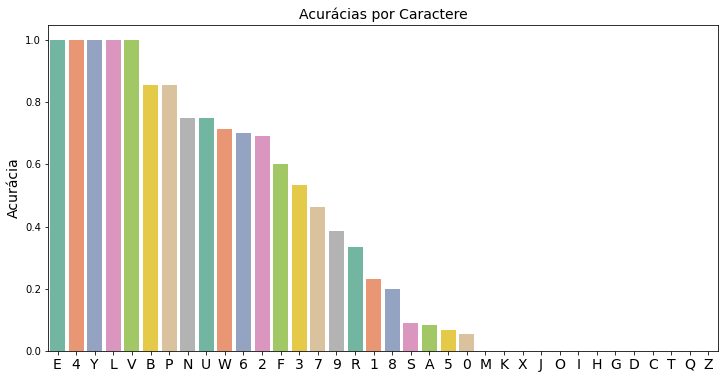

In [37]:
summary_plot(_df_acc)

# Testando outras bases

In [38]:
# testando o modelo para as diferentes versões
# da base sintética, para diferentes fontes e
# diferentes espessuras das letras

base_names = ['sintetic_simplex',
              'sintetic_simplex_h',
              'sintetic_simplex_t',
              'sintetic_script',
              'sintetic_script_h']

clf = PlateClassifier()
clf.fit(X_train=sintetic_simplex, y_train=alf, stats=df_grouped)

results = {}
for sintetic_base, idx in zip(sintetic_basis, range(len(sintetic_basis))):
    clf.fit(X_train=sintetic_base, y_train=alf, stats=df_grouped)

    preds = []
    for i, y_true in zip(range(len(components)), plates_texts):
        X_test = components[i]

        pred = clf.predict(X_test, split=False, verbose=False, show_scores=False)
        preds.append(pred)

    results[base_names[idx]] = preds
results['stats'] = _preds


BASE SINTETIC_SIMPLEX

accuracy = 0.17777777777777778
hits = 8 of 45
accuracy = 0.7189542483660131
hits = 220 of 306


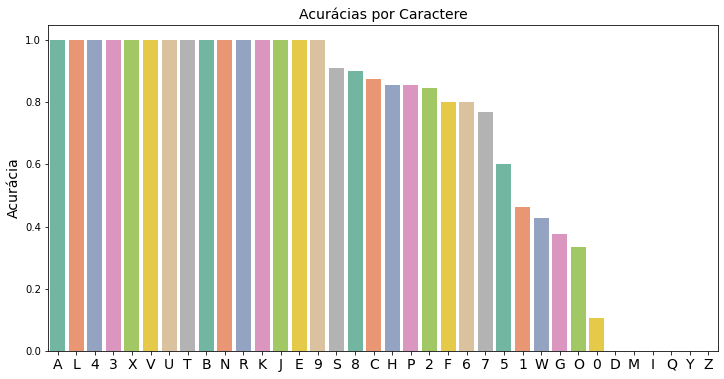


BASE SINTETIC_SIMPLEX_H

accuracy = 0.06666666666666667
hits = 3 of 45
accuracy = 0.6143790849673203
hits = 188 of 306


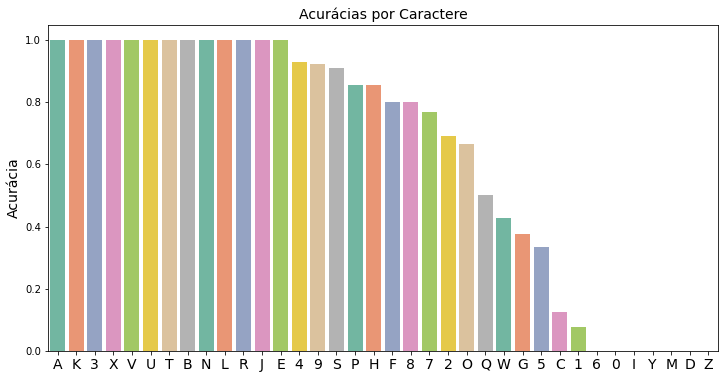


BASE SINTETIC_SIMPLEX_T

accuracy = 0.13333333333333333
hits = 6 of 45
accuracy = 0.6470588235294118
hits = 198 of 306


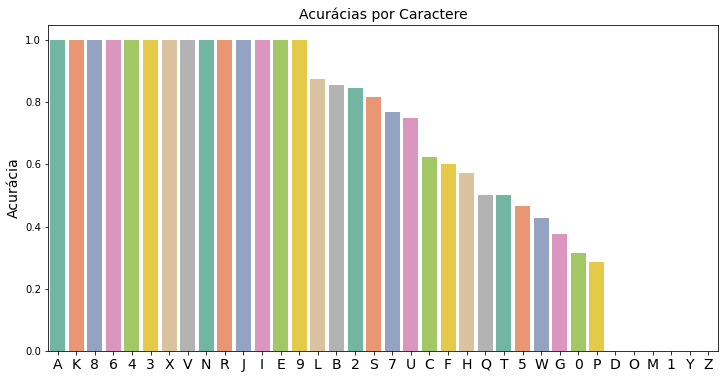


BASE SINTETIC_SCRIPT

accuracy = 0.022222222222222223
hits = 1 of 45
accuracy = 0.4738562091503268
hits = 145 of 306


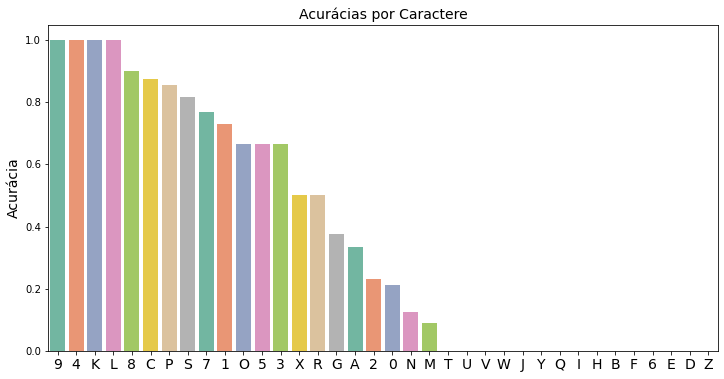


BASE SINTETIC_SCRIPT_H

accuracy = 0.022222222222222223
hits = 1 of 45
accuracy = 0.4084967320261438
hits = 125 of 306


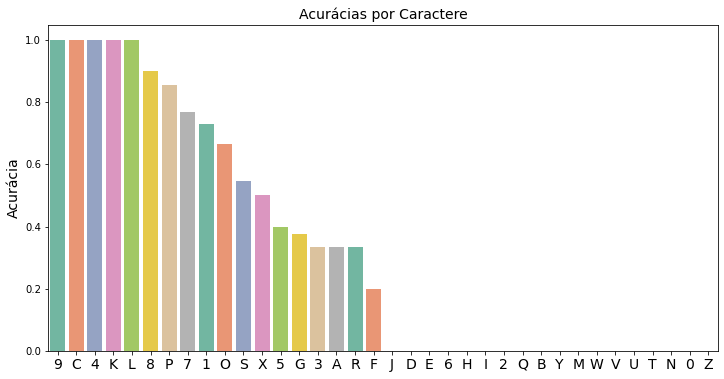


BASE STATS

accuracy = 0.0
hits = 0 of 45
accuracy = 0.369281045751634
hits = 113 of 306


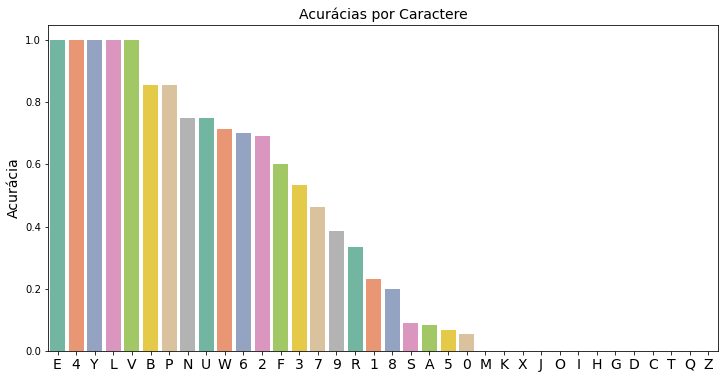

In [39]:
for k, v in zip(list(results.keys()),
                list(results.values())):
    print('\nBASE', k.upper(), end='\n\n')

    df_results = prediction_results(v, plates_texts)

    print('accuracy =', df_results['equal'].sum() / len(df_results))
    print('hits =', df_results['equal'].sum(), 'of', len(df_results))
    print('accuracy =', df_results['hits'].sum() / df_results['len'].sum())
    print('hits =', df_results['hits'].sum(), 'of', df_results['len'].sum())

    df_acc = summary_results(df_results)
    summary_plot(df_acc)

In [40]:
df_predictions = pd.DataFrame()
df_predictions['true'] = plates_texts
df_predictions.set_index('true', inplace=True)

for k, v in zip(list(results.keys()),
                list(results.values())):
    df_predictions[k] = v

df_predictions

sintetic_simplex sintetic_simplex_h sintetic_simplex_t sintetic_script sintetic_script_h     stats
true                                                                                                       
AAAA000           AAAABBB            AAAABBB            AAAA000         AAAAS00           AAAASSS   LLAAKNN
AAAA111           AAAA333            AAAA333            AAAA333         AAAAEEE           AAAAEEE   LLLLXXX
ABA1234           ABA1234            ABA2234            ABA2234         RSR1E34           HSR1PZ4   JBJ4214
ABGAP33           ABBAP33            ABBAP33            ABBA933         HSSHPZZ           HSSHPZZ   JBWJP11
ANAL334           ANAL334            ANAL334            ANA5334         QSQLH34           RSQLHZ4   JNJL414
ANCL550           ANCLBBB            ANELBBD            ANCL6BB         HSCLSSS           HSCLSSS   6NDLRBX
BLAM414           BLAN424            BLAH424            BLAN424         SLHS414           SLHS414   BLJR444
BMW6220           BNW822D            BHW522D            BNW622B         SSM822S           SSM8EES   BR6622K
BN15858           BN2B8B8            BN2B8BB            BNI6868         SS1S858           SS1S8S8   BN4RBBB
BQ708GP           B070BGP            BQ7OBGP            BQ708GP         S070SGP           SO7OSGP   BUYQBSP
BRL702             BRL7B2             BRL7D2             BRL702          SRL7SE            SSL7SE    BRL707
ES344               ES344              ES344              ES344           K3344             K3Z44     EV344
FCK469             FCK469             FCK459             FCK469          PCK459            FCK459    FVV4J9
FD2107H          BFB21D7K           BFB21D7K           6F92IB7K        8GBE1SF7          8SBE1SF7  XFT24K74
FOW653             FON653             FON5B3             F0N653          SOM553            POM55Z    FAW651
GAJ169             BAJ269             BAJ259             6AJI69          SHS159            5HS159    WJ44SI
HGAA7034         HBAAZB34           HBAAZD34           H6AAZB34        SSRHFSH4          SSRRFSH4  BW66PX34
HH07194           HHB7194            HHU719A            HHB7294         SSS7194           SSS7194   BNWY494
HHRD41             HHRB42             HHRB42             8HR84I          SSRB41            SSNB41    RGDW44
HROD819           HRO8829            HROB829            BR098I9         SHOB819           SROB819   RCATQ4I
INA6310           ZNA631B            ZNA531D            INA63IB         XSR831S           XSR531S   1B2631X
KSC124             KSC124             KSE224             KSC224          KSC1Z4            KSC1X4    SMF4H4
LA5079             LA5079             LA5O79             LA6979          LH5O79            LH5C79    LJM6YI
MAP7563           NAP7563            HAP7B53            NA97563         SRP755S           SRP7S5S   BJP7R63
MBCL600           HBCL6BB            HBEL5DB            NBCL6BB         SSCL5SS           SSCL5SS   RDVL6KK
MBDT781           NB8T781            HBBT782            NB9I78I         SSBY781           SSBY781   RBTYY8Y
MDT5157           NBT5257            HBTB2B7            N9T5257         SBY5157           SBIS157   RTYC4C7
MGX1234           NBX1Z34            NBX2Z34            NBXI234         SSX1Z34           SSX1E34   BXA4234
PG589G             PGS89G             PGS89G             PG689G          PGS89G            PGH89G    PA989A
QLGX125           DLBX125            ULBX225            0LBX225         0LSM12B           SLSM1PB   XLX8121
RUDCN890         RUBCN89B           RUBEN8DD           RU86N89B        NSBCS890          SSBCS89S  BBXFNKTX
SLSC56             SLSC56             SLSE55             SLSC66          SLSC55            SLSC55    VLALCA
SMB2062           SNB2B52            SHB2D5Z            SNB2B62         SSSZS5Z           SSSPS5E   ARB2K62
SMB2078           SNB2D78            SHBZD78            SN82078         SS8ZS78           3S8HS78   ARK2W7N
SMC1735           SND1735            SHD2735            8N6I735         SMG1735           3SC1735   QBG473R
SMC9348      

# Realizando um teste com `RandomForest`

In [41]:
X = df.drop('label', axis=1).values
y = df['label'].values

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.5, random_state=42
)

In [43]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [44]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.36      0.45      0.40        11
           1       0.42      0.29      0.34        17
           2       0.40      0.67      0.50         6
           3       0.80      0.50      0.62         8
           4       0.50      0.57      0.53         7
           5       0.12      0.20      0.15         5
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         5
           8       0.33      0.50      0.40         4
           9       0.27      0.50      0.35         6
           A       0.80      0.57      0.67        14
           B       0.53      0.89      0.67         9
           C       0.00      0.00      0.00         5
           D       0.00      0.00      0.00         4
           E       0.00      0.00      0.00         2
           F       1.00      0.50      0.67         2
           G       0.00      0.00      0.00         4
           H       0.00    

In [45]:
df_output = prediction_results(pred, y_test)
df_acc = summary_results(df_output)
df_acc

hits of total  accuracy
A       8 of 14  0.571429
B        8 of 9  0.888889
C        0 of 5  0.000000
D        0 of 4  0.000000
E        0 of 2  0.000000
F        1 of 2  0.500000
G        0 of 4  0.000000
H        0 of 4  0.000000
I        0 of 0       NaN
J        0 of 0       NaN
K        0 of 0       NaN
L        3 of 5  0.600000
M        0 of 6  0.000000
N        1 of 1  1.000000
O        0 of 3  0.000000
P        0 of 6  0.000000
Q        0 of 1  0.000000
R        0 of 1  0.000000
S        1 of 4  0.250000
T        0 of 0       NaN
U        0 of 1  0.000000
V        1 of 1  1.000000
W        3 of 4  0.750000
X        0 of 1  0.000000
Y        0 of 0       NaN
Z        0 of 0       NaN
0       5 of 11  0.454545
1       5 of 17  0.294118
2        4 of 6  0.666667
3        4 of 8  0.500000
4        4 of 7  0.571429
5        1 of 5  0.200000
6        0 of 6  0.000000
7        0 of 5  0.000000
8        2 of 4  0.500000
9        3 of 6  0.500000

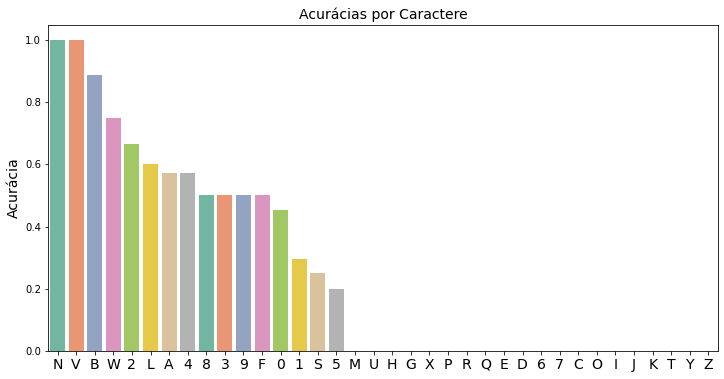

In [46]:
summary_plot(df_acc)